In [ ]:
!pip install requests
!pip install matplotlib
from typing import List

# Language detection in 7 minutes
## Paweł Kubiak


## Language Detection. Why?
Before we start any analysis of the text we need to know its language. We need to know it to decide which dictionary to download, which language model to load or which algorithm to use. Language is **must-have**.

## Corpus collecting
In order to train our model, we will need a lot of text in different languages. For example, we can use:

- [European Parliament Proceedings Parallel Corpus](https://www.statmt.org/europarl/) (21 langs)
- [Universal Declaration of Human Rights]() (524 langs)
- [Books / documents from WikiBooks project](https://en.wikibooks.org/wiki/Main_Page) (76 langs)
- [Wikipedia articles](https://en.wikipedia.org/wiki/Special:Statistics) (314 langs)

## Collect Wikipedia articles
We use MediaWiki API <sup>[1]</sup> to extract article plaintext:

In [2]:
import requests

def get_wikipedia(lang: str, title: str) -> str:
    """Extract wikipedia article as plaintext using API."""
    req = requests.get(
        f"https://{lang}.wikipedia.org/w/api.php",
        params=dict(
            action="query", format="json", prop="extracts",
            titles=title, explaintext=True, redirects=True
    )).json()
    
    return list(req['query']['pages'].values())[0]['extract']

## Sample Wikipedia article

In [3]:
kapibara = get_wikipedia('pl', 'kapibara')
print(kapibara[:400])

Kapibara (Hydrochoerus) – rodzaj ssaka z podrodziny kapibar (Hydrochoerinae) w rodzinie kawiowatych (Caviidae).


== Zasięg występowania ==
Rodzaj obejmuje gatunki występujące w Ameryce Środkowej (Panama) i Południowej (Kolumbia, Wenezuela, Gujana, Brazylia, Ekwador, Peru, Boliwia, Paragwaj, Argentyna i Urugwaj).


== Morfologia ==
Długość ciała (bez ogona) 1025–1340 mm, długość ogona 10–20 mm, dł


## Text cleaning

In [4]:
import re

def clean(text):
    text = re.sub('[_\W\d]', ' ', text)  # non-alphanumeric and digits
    text = re.sub('\s+', ' ', text.strip())  # normalize whitespaces
    text = text.lower()  # convert to lowercase

    return text

czysta_kapibara = clean(kapibara[:300])
print(czysta_kapibara)

kapibara hydrochoerus rodzaj ssaka z podrodziny kapibar hydrochoerinae w rodzinie kawiowatych caviidae zasięg występowania rodzaj obejmuje gatunki występujące w ameryce środkowej panama i południowej kolumbia wenezuela gujana brazylia ekwador peru boliwia paragwaj argenty


## What are N-grams? ##

> An N-gram is a contiguous sequence of n items from a given sample of the text. The items can be phonemes, syllables, letters or words according to the application.<br/><small>Wikipedia, The Free Encyclopedia<sup>[2]</sup></small>

## What are N-grams? ##

- (*unigram*) &LongRightArrow; p, y, c, o, n 
- (*bigram*) &LongRightArrow; py, yc, co, on 
- (*trigram*) &LongRightArrow; pyc, yco, con 

### N-grams in Python

In [5]:
def make_ngrams(text: str, n: int) -> List[str]:
    """Generate all n-grams of length `n` from `text`."""
    for i in range(n, len(text)+1):
        yield text[i-n:i]

list(make_ngrams("pycon2020", 3))

['pyc', 'yco', 'con', 'on2', 'n20', '202', '020']

## Top N-grams

> The top 300 or so N-grams are almost
always highly correlated to the language. ... Starting around rank 300 or so, an N-gram frequency profile begins to show N-grams that are more specific to the subject of the document.<br/>
<small>N-Gram-Based Text Categorization<sup>[3]</sup></small>


## N-grams ranking in Python

In [6]:
from collections import Counter

def ranking(text: str, topn: int) -> List[str]:
    """
    Collect N-grams of given lengths from `text`.
    Return `topn` most common N-grams.
    """
    counts = Counter()
    words = text.split()
    for length in [1, 2, 3]:
        for word in words:
            counts.update(make_ngrams(f"_{word}_", length))
        
    return [key for key, _ in counts.most_common(topn)]

## Sample N-grams rankings for PL

In [7]:
text = clean(get_wikipedia('pl', 'Linux'))

rank = ranking(text, 200)
print(', '.join(rank))

_, a, e, i, o, n, r, s, t, w, z, y, c, u, m, k, p, d, l, j, e_, a_, ie, ni, st, g, _p, in, _s, na, i_, ow, _w, li, er, _n, b, h, y_, te, ch, _z, o_, ż, ro, ra, _l, ó, ą, po, an, h_, _o, _i, _d, wa, ch_, ko, _t, nie, w_, _na, m_, nu, _li, ie_, ł, f, ny, ac, _m, pr, _k, lin, inu, ę, wi, za, cz, je, ne, yc, rz, ze, _j, _po, ys, em, x, z_, do, _g, u_, yst, ia, ych, mi, na_, _pr, ów, al, ej, t_, zy, or, od, ą_, ś, _u, _a, on, owa, op, to, ta, ic, en, x_, ar, os, cj, _i_, ux, _r, sz, ki, wan, _je, nux, wy, le, ty, om, _ko, _w_, ym, es, gr, aj, mo, _za, sy, ją, ani, go, ste, eg, j_, tem, wn, ak, si, ów_, ter, ć, ks, dz, ć_, _z_, la, ux_, _sy, sys, rze, pro, ne_, tr, so, we, ię, ka, rac, _do, em_, ob, ed, wo, ró, ę_, uż, est, go_, ej_, dy, sa, ma, ego, sta, fi, me, st_, am, ec, ry, is, nyc, ym_, sk, _op, era


## Hypothesis

> Texts in the same language generate similar N-gram rankings, while for different languages the rankings will differ strongly.

In [8]:
import matplotlib.pyplot as plt

def rank_wiki(name, n=200):
    t = clean(get_wikipedia(*name.split(':', 1)))
    return ranking(t,n)
    
def vizualize_rankings(ax, n1, n2, n=100):
    r1 = rank_wiki(n1, n)
    r2 = rank_wiki(n2, n)
    m = [
        [i == j if (j in r1 and i in r2) else 0.1 for j in r2]
        for i in r1
    ]
    
    ax.imshow(m)
    ax.set_xticks([])
    ax.set_xlabel(n1, fontsize=18)
    ax.set_yticks([])
    ax.set_ylabel(n2, fontsize=18)

## Rankings correlation

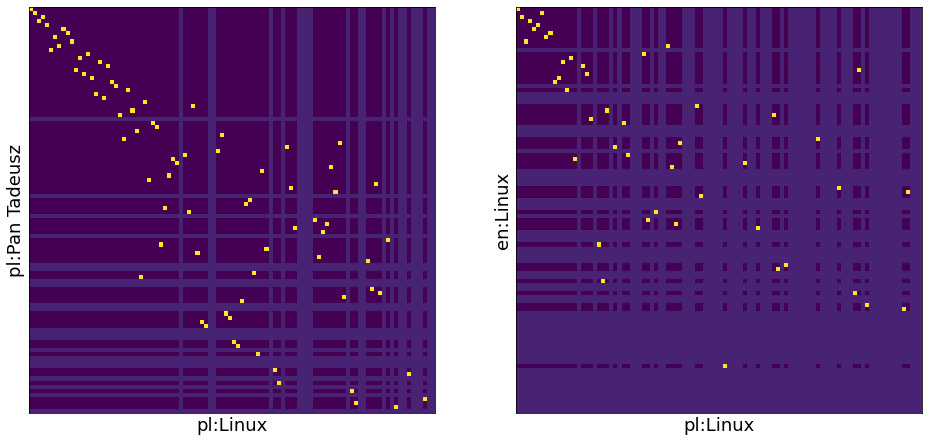

In [9]:
_, ax =plt.subplots(1, 2, figsize=(16,8))
vizualize_rankings(ax[0], 'pl:Linux', 'pl:Pan Tadeusz')
vizualize_rankings(ax[1], 'pl:Linux', 'en:Linux')

## Rankings Distance Measure
> ![N-gram ranking distance](https://www.researchgate.net/profile/William_Cavnar/publication/2375544/figure/fig2/AS:669559593898000@1536646855685/Calculating-The-Out-Of-Place-Measure-Between-Two-Profiles.png)
<small>N-Gram-Based Text Categorization<sup>[3]</sup></small>


## Rankings Distance Measure in Python

In [10]:
def distance(rank1: List[str], rank2: List[str]) -> int:
    """Compute distane between two N-grams rankings."""
    score = 0
    for i, key in enumerate(rank1):
        if key in rank2:
            score += abs(rank2.index(key) - i)
        else:
            score += len(rank2) # MAX penalty
    return score

In [11]:
(
    distance(rank_wiki('pl:Linux'), rank_wiki('pl:Pan Tadeusz')),
    distance(rank_wiki('pl:Linux'), rank_wiki('en:Linux'))
)

(14956, 23623)

## N-grams Language Detector

In [12]:
class LinuxLanguageDetector:
    """Detect text language based on N-grams model."""
    def __init__(self, langs: List[str], n: int = 200):
        self.n = n
        self.ranks = {
            lang: rank_wiki(f"{lang}:Linux", n)
            for lang in langs
        }
        
    def detect(self, text: str) -> str:
        rank = ranking(clean(text), self.n)
        return min(
            self.ranks,
            key=lambda lang: distance(rank, self.ranks[lang])
        )

## Testing

In [13]:
langdet = LinuxLanguageDetector(['pl', 'en', 'de', 'fr', 'it'])

In [14]:
langdet.detect("PyCon PL 2020 to trzynasta edycja "
    "ogólnopolskiej konferencji z grupy PyCon.")

'pl'

In [15]:
langdet.detect("Python è un linguaggio di programmazione di più "
    "alto livello rispetto alla maggior parte degli altri linguaggi.")

'it'

In [16]:
langdet.detect("Capybaras are highly social, living in groups of up "
    "to 100 and communicating through a variety of vocalizations.")

'en'

## Evaluation on Sample Articles

In [17]:
def wiki_randomize(lang: str, limit: int) -> List[str]:
    """Return random wikipedia articles' titles."""
    data = requests.get(
        f"https://{lang}.wikipedia.org/w/api.php",
        params=dict(action="query", format="json", generator="random",
                    grnnamespace=0, grnlimit=limit, prop="info"
    )).json()
    return [page['title'] for page in data['query']['pages'].values()]

wiki_randomize('pl', 10)

['Ołeksij Bahniuk',
 'Iisaku',
 'Dayot Upamecano',
 'Babin Średni',
 'Papierówka (jabłoń)',
 'Emil Michałowski',
 'Eschenburg',
 'Ja, Najwyższy',
 'Antoni Słociński',
 'Douglas Bay']

In [18]:
def evaluate(model, n=10, cutoff=5):
    """Evaluate model on random wikipedia articles."""
    langs = list(model.ranks.keys())
    counts, counts_cut = Counter(), Counter()
    for lang in langs:
        for title in wiki_randomize(lang, n):
            text = get_wikipedia(lang, title)
            counts[(lang, model.detect(text))] += 1
            
            text = ' '.join(clean(text).split()[:cutoff])
            counts_cut[(lang, model.detect(text))] += 1

    return langs, counts, counts_cut


def show_matrix(ax, langs, data):
    data = [
        [data[(expected, detected)] for detected in langs]
        for expected in langs
    ]
    ax.imshow(data)
    ax.set_xticks(range(len(langs)))
    ax.set_xticklabels(langs)
    ax.set_xlabel("detected", fontsize=18)
    ax.set_yticks(range(len(langs)))
    ax.set_yticklabels(langs)
    ax.set_ylabel("expected", fontsize=18)
    for i in range(len(langs)):
        for j in range(len(langs)):
            val = data[i][j]
            text = ax.text(j, i, val, ha="center", va="center", color="k" if val else "w", fontsize=24)
    

def show_evaluation(model, n):
    _, ax = plt.subplots(1, 2, figsize=(16, 8))
    langs, full_text, with_cutoff = evaluate(model, n)

    N = sum(full_text.values())
    acc = 100 * sum(full_text[i,i] for i in langs) / N
    ax[0].set_title("Full Text (acc: %.2f%%, n: %d)" % (acc,N), fontsize=22)
    show_matrix(ax[0], langs, full_text)

    acc = 100 * sum(with_cutoff[i,i] for i in langs) / N
    ax[1].set_title("First 5 words (acc: %.2f%%, n: %d)" % (acc, N), fontsize=22)
    show_matrix(ax[1], langs, with_cutoff)

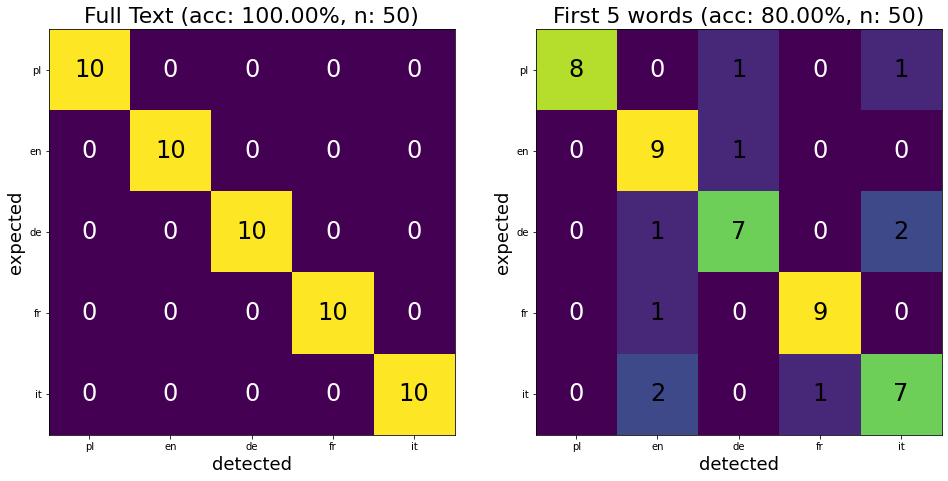

In [23]:
show_evaluation(langdet, n=10)

## Pros and Cons

<ul style="list-style-type: none; padding-left:1em">
    <li>&check; Very simple idea and implementation</li>
    <li>&check; Low memory requirement of the trained model (only n-gram rankings)</li>
    <li>&check; Fast trainable (no gradients optimization)</li>
    <li>&check; High tolerance for errors</li>
    <li>&cross; Poorly handles short and mixed texts</li>
</ul>

## Don't try this at work - Use nltk
The same n-gram based method has been implemented in nltk package.

In [ ]:
!pip install nltk

Before the first run we must download additional language resources.

In [ ]:
import nltk
nltk.download('crubadan');

## Don't try this at work - Use nltk

In [22]:
from nltk.classify.textcat import TextCat
textcat = TextCat()

pl = textcat.guess_language("PyCon PL 2020 to trzynasta edycja "
    "ogólnopolskiej konferencji z grupy PyCon.")

en = textcat.guess_language("Capybaras are highly social, "
    "living in groups of up to 100 and communicating through "
    "a variety of vocalizations.")

(pl, en)

('pol', 'eng')

## References

1. [MediaWiki API Help.](https://www.mediawiki.org/w/api.php?action=help&modules=query%2Bextracts)
2. [Wikipedia contributors, "N-gram," Wikipedia, The Free Encyclopedia](https://en.wikipedia.org/wiki/N-gram)
3. [Cavnar, W. B. and Trenkle, J. M. 1994. N-gram-based text categorization](https://www.researchgate.net/publication/2375544_N-Gram-Based_Text_Categorization)

## Thank you for your attention :)

https://github.com/pkubiak/pl.pycon.2020